In [436]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys
from sklearn.model_selection import train_test_split # train , test 분리에 사용.

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [437]:
from tqdm import tqdm
from datetime import datetime

# 데이터 전처리

```

TurbID - 발전기 ID

Day - 날짜

Tmstamp - 시간

Wspd - 풍속

Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이

Etmp - 외부 온도

Itmp - 터빈 내부 온도

Ndir - 터빈이 바라보는 방향 각도

Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름

Prtv - 무효전력 : 에너지원을 필요로 하지 않는 전력

Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력

````


베이스 라인 제공 전처리 방법

In [438]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [439]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [440]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
train_data = train_data.fillna(method = 'ffill').fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64


In [441]:
train_data[(train_data["TurbID"]==1)&(train_data["Day"]==1)]

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1,1,23:10,9.95,0.49,28.71,42.53,-9.44,1.02,1.02,1.02,-0.29,1330.24
140,1,1,23:20,12.20,0.70,28.59,42.56,-8.17,1.08,1.08,1.08,-0.23,1550.74
141,1,1,23:30,12.66,1.09,28.54,42.23,-8.17,1.08,1.08,1.08,-0.21,1549.66
142,1,1,23:40,12.58,1.70,28.48,42.09,-8.17,1.08,1.08,1.08,-0.20,1549.64


In [442]:
train_data=train_data[train_data["TurbID"]==1]

In [443]:
train_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,1,200,23:10,4.70,-0.04,10.46,27.67,201.38,0.99,0.99,0.99,-0.29,296.34
28796,1,200,23:20,3.53,-2.37,11.32,28.65,191.85,0.99,0.99,0.99,-0.22,178.46
28797,1,200,23:30,3.50,-0.65,11.81,29.29,187.51,0.99,0.99,0.99,-0.24,164.19
28798,1,200,23:40,4.26,0.50,10.08,28.13,187.51,0.99,0.99,0.99,-0.28,259.42


In [444]:
# Y value 추가
train_data['Wspd_y']=train_data['Wspd']

# 데이터셋

In [375]:
#train_data['Wspd']=train_data['Wspd'].shift(+1).fillna(method="bfill")

In [376]:
# X 값들 수정해주기
#for dat in X_data:
#    dat[:,1]=np.log1p(dat[:,1])



In [377]:
train_data.loc[0:59]

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Wspd_y
0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,6.17
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,6.17
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,6.27
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,6.42
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,6.25
5,1,1,00:50,6.10,-1.03,30.47,41.22,20.91,1.00,1.00,1.00,-0.27,482.21,6.10
6,1,1,01:00,6.77,1.07,30.31,41.19,20.91,1.00,1.00,1.00,-0.23,584.75,6.77
7,1,1,01:10,6.70,-2.80,30.24,41.00,20.91,1.00,1.00,1.00,-0.23,557.98,6.70
8,1,1,01:20,6.44,-3.46,30.13,40.91,20.91,1.00,1.00,1.00,-0.21,503.94,6.44
9,1,1,01:30,6.25,-3.15,29.97,40.72,20.91,1.00,1.00,1.00,-0.26,463.37,6.25


In [445]:
# 한 Turb당 194 line
# label은 2일.로 나눠야함.

train_seq = 40




def make_train_data(data):
    train_x, train_y = [], []
    for i in sorted(pd.unique(data["TurbID"])):
        tmp_data = data[data["TurbID"] == i]
        
        for train_ind in tqdm(range(0,28600-train_seq)):
            
            train_tmp = tmp_data.loc[train_ind:train_ind+train_seq-1 ]['Wspd']
            label_tmp = tmp_data[ tmp_data.index == train_ind+train_seq ]["Wspd_y"]
            
            #train_tmp = train_tmp.drop(["TurbID","Tmstamp","Day","Patv","Pab2","Pab3","Etmp","Ndir","Wspd_y"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y


def make_valid_data(data):
    train_x, train_y = [], []
    for i in sorted(pd.unique(data["TurbID"])):
        tmp_data = data[data["TurbID"] == i]
        
        for train_ind in tqdm(range(28600,28800-train_seq)):
            
            train_tmp = tmp_data.loc[train_ind:train_ind+train_seq-1 ]['Wspd']
            label_tmp = tmp_data[ tmp_data.index == train_ind+train_seq ]["Wspd_y"]
            
            #train_tmp = train_tmp.drop(["TurbID","Tmstamp","Day","Patv","Pab2","Pab3","Etmp","Ndir","Wspd_y"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y


In [446]:
#train_data = train_data[train_data['TurbID']==21]

In [411]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
nor = MinMaxScaler()# 
y_nor = MinMaxScaler()

train_data[["Wspd","Wdir","Itmp","Pab1","Prtv"]] = nor.fit_transform(train_data[["Wspd","Wdir","Itmp","Pab1","Prtv"]])
train_data[["Wspd_y"]] = y_nor.fit_transform(train_data[["Wspd_y"]])

#["TurbID", "Day","Patv","Etmp","Ndir"]

In [412]:
train_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Wspd_y
0,1,1,00:00,0.265948,0.490830,30.73,0.956602,25.92,0.217391,1.00,1.00,0.996876,494.66,0.265948
1,1,1,00:10,0.265948,0.490830,30.73,0.956602,25.92,0.217391,1.00,1.00,0.996876,494.66,0.265948
2,1,1,00:20,0.270259,0.495953,30.60,0.956086,20.91,0.217391,1.00,1.00,0.996926,509.76,0.270259
3,1,1,00:30,0.276724,0.500057,30.52,0.955751,20.91,0.217391,1.00,1.00,0.996826,542.53,0.276724
4,1,1,00:40,0.269397,0.504642,30.49,0.955326,20.91,0.217391,1.00,1.00,0.996975,509.36,0.269397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,1,200,23:10,0.202586,0.502010,10.46,0.913661,201.38,0.208696,0.99,0.99,0.996678,296.34,0.202586
28796,1,200,23:20,0.152155,0.495415,11.32,0.916639,191.85,0.208696,0.99,0.99,0.997025,178.46,0.152155
28797,1,200,23:30,0.150862,0.500283,11.81,0.918584,187.51,0.208696,0.99,0.99,0.996926,164.19,0.150862
28798,1,200,23:40,0.183621,0.503538,10.08,0.915059,187.51,0.208696,0.99,0.99,0.996727,259.42,0.183621


In [413]:
y_nor.scale_

array([0.04310345])

In [414]:
#실험
#nor.min_=nor.min_[0]
#nor.scale_=nor.scale_[0]

In [415]:
y_nor.inverse_transform(train_data[["Wspd_y"]])

array([[6.17],
       [6.17],
       [6.27],
       ...,
       [3.5 ],
       [4.26],
       [3.97]])

In [447]:
#tms_list = list(pd.unique(train_data["Tmstamp"]))
#train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x) )
#train_data["Tmstamp"] = train_data["Tmstamp"]//6
#hour_list = [datetime.strptime(t,"%H:%M").hour for t in tms_list]
#train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : hour_list[tms_list.index(x)] )


X_data, Y_data = make_train_data(train_data)
valid_X_data, valid_Y_data = make_valid_data(train_data)

100%|██████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 5333.59it/s]


In [448]:
len(X_data)# 5일학습 기준 윈도우는 터빈당 194개. 194개 마다 hidden state 초기화 필요,

28560

In [449]:
len(valid_X_data)

160

In [450]:
pd.DataFrame(X_data[0])

,0
0,6.17
1,6.17
2,6.27
3,6.42
4,6.25
5,6.10
6,6.77
7,6.70
8,6.44
9,6.25


In [420]:
from datetime import datetime
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)
#출처: https://today-1.tistory.com/55 [Better Than,:티스토리]

In [14]:
# time stamp label encoding
tms_list = list(pd.unique(train_data["Tmstamp"]))
hour_list = [datetime.strptime(t,"%H:%M").hour for t in tms_list]

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : hour_list[tms_list.index(x)] )


# Fourier Features
train_data['sin_24_1'] = np.sin(2 * np.pi * train_data['Tmstamp']/23.0)
train_data['cos_24_1'] = np.cos(2 * np.pi * train_data['Tmstamp']/23.0)
fourier_features(train_data['Tmstamp'], 24, 1)

train_data.drop(['Tmstamp'],axis=1,inplace=True)

X_data, Y_data = make_train_data(train_data)
#valid_x, valid_y = make_valid_data(train_data)


 database. History logging moved to new session 1439


TypeError: strptime() argument 1 must be str, not numpy.int64

In [19]:
#train_y, valid_y, train_x, valid_x = temporal_train_test_split(X=X_data,y=Y_data, test_size=0.1 )
# 0.1 validation :117~121 , ...순서가 잘못됨.
# 0.05 validation :

In [457]:
X_data[0].shape[0]

40

In [456]:
np.array(X_data).

(28560, 40)

In [459]:
train_x  = np.array(X_data).reshape(-1, X_data[0].shape[0], 1)
train_y= np.array(Y_data)


valid_x  = np.array(valid_X_data).reshape(-1, valid_X_data[0].shape[0], 1)
#train_x = np.array(X_data)
valid_y = np.array(valid_Y_data)

print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)

# 한터빈당 20개의 배치를 가진다.

(28560, 40, 1) (28560, 1)
(160, 40, 1) (160, 1)


In [460]:
pd.DataFrame(valid_x[0])

,0
0,15.59
1,14.40
2,14.66
3,13.99
4,14.74
5,14.50
6,7.69
7,6.41
8,5.90
9,5.23


input dimension은 (Batch, Time_step, Feature dimension) 순이다. (batch_first=True)

output이 288인 이유는 2일이라서

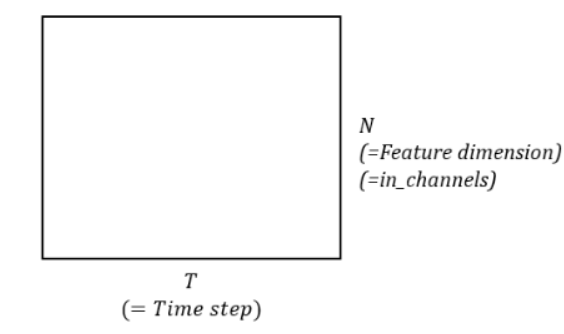

# 데이터 로더

In [461]:
EPOCHS = 30
BATCH_SIZE = 128
lr = 1e-3

In [462]:
from torch.utils.data import Dataset, DataLoader

class TimeDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        
        return torch.Tensor(self.X[index]) # 테스트셋 용
    


In [463]:
train_dataset = TimeDataset(train_x, train_y)
valid_dataset = TimeDataset(valid_x, valid_y)


train_loader = DataLoader(train_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)

valid_loader = DataLoader(valid_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)



# 데이터 확인

In [464]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0].shape)


X_train :  torch.Size([128, 40, 1]) type: torch.FloatTensor
Y_train :  torch.Size([128, 1]) type: torch.FloatTensor
torch.Size([1])


In [465]:
#valiation set 확인
for (X_valid,Y_valid) in valid_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0].shape)

X_valid :  torch.Size([128, 40, 1]) type: torch.FloatTensor
Y_valid :  torch.Size([128, 1]) type: torch.FloatTensor
torch.Size([1])


# 모델


### input 설명

- input_size: input의 feature dimension을 넣어주어야 한다. time step이 아니라 feature dimension!
- hidden_size: 내부에서 어떤 feature dimension으로 바꿔주고 싶은지를 넣어주면 된다.
- num_layers: lstm layer를 얼마나 쌓을지
- bias: bias term을 둘 것인가 (Default: True)
- batch_first: batch가 0번 dimension으로 오게 하려면 이거 설정! 난 이거 설정 가정하고 설명했다. (Default: False)
- dropout: 가지치기 얼마나 할지, generalization 잘안되면 이걸 조정하면 된다.
bidirectional: 양방향으로 할지 말지 (bidirectional 하면 [forward, backword] 로 feature dimension 2배 됨)



참고.

https://sanghyu.tistory.com/52

### output 설명

- outputs는 (output, (hidden or hidden stat,cell stat)) 의 tuple 형태로 나오므로 주의해서 써야한다. (LSTM만 cell state있음)
- output: output dimension은 (batch, time_step, hidden dimension) 순이다. 양방향일 경우 hidden_size*2
- hidden state: 모든 layer의 hidden state를 담고있다.
- cell state: 모든 layer의 cell state를 담고있다.

In [105]:
lstm = nn.LSTM(input_size=12, hidden_size=256, batch_first=True, bidirectional=False)

lstm(X_valid)[0].size()

RuntimeError: input.size(-1) must be equal to input_size. Expected 12, got 6

In [106]:
lstm(X_valid)[0][-1].size()

RuntimeError: input.size(-1) must be equal to input_size. Expected 12, got 6

In [107]:
lstm(X_valid)[1][0]

RuntimeError: input.size(-1) must be equal to input_size. Expected 12, got 6

In [29]:
lstm(X_valid)[0][:,-2,:].size()

torch.Size([128, 256])

In [70]:
c1 = nn.Conv1d(in_channels=720, out_channels=488, kernel_size = 3, stride = 1,padding=1) # 1D CNN 레이어 추가
c2 = nn.Conv1d(in_channels=488, out_channels=256, kernel_size = 3, stride = 1,padding=1) # 1D CNN 레이어 추가
pool1 = nn.MaxPool1d(kernel_size=3,stride=1)


o1 = c1(X_valid)
print(o1.size())
#o2 = pool1(o1)
#print(o1.size())

o2 = c2(o1)
print(o2.size())
o3 = pool1(o2)
print(o3.size())
#c1(X_valid).size()

torch.Size([128, 488, 6])
torch.Size([128, 256, 6])
torch.Size([128, 256, 4])


In [466]:
lstm_hidden_size= 64
lstm_input_size = 1

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=lstm_hidden_size, batch_first=True,
                           bidirectional=True)
        #self.c1 = nn.Conv1d(in_channels=720, out_channels=488, kernel_size = 3, stride = 1,padding=1) # 1D CNN 레이어 추가
        #self.c2 = nn.Conv1d(in_channels=488, out_channels=488, kernel_size = 3, stride = 1,padding=1) # 1D CNN 레이어 추가
        #self.c3 = nn.Conv1d(in_channels=488, out_channels=288, kernel_size = 3, stride = 1,padding=1) # 1D CNN 레이어 추가
        
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_size*2,64),# 사이즈는 hidden size에 따라 결정.
            nn.ReLU(),
            nn.Linear(64,1), #결과 1개 예측.
            nn.ReLU(),  
        )
    

        
    def forward(self, x):
        #x = self.c1(x)
        #x = self.c2(x)
        #x = self.c3(x)
        #x = self.pool1(x)
        
        output,_ = self.lstm(x)
        output = self.classifier(output[:,-1,:]) # -1은 hidden state의 마지막 time step값을 가져온 것.
        return output

In [467]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    train_loss = 0
    train_mae_loss = 0
    for batch_idx,(X, Y) in enumerate(train_loader):
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
        
        optimizer.zero_grad()#데이터들 장비에 할당
        output = model(X) # model로 output을 계산
        loss = criterion(output, Y)        
        train_loss += loss.item()
        
        with torch.no_grad():
            mae = metric(output, Y)
            train_mae_loss+=mae.item()
        loss.backward()
        optimizer.step()
    
    #train_loss/=len(train_loader.dataset)
    #train_mae_loss/=len(train_loader.dataset)
    
    return train_loss,train_mae_loss
    


In [468]:
#8. 학습
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    valid_mae = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for X, Y in valid_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            output = model(X) # model로 output을 계산
            
            loss = criterion(output, Y)
            valid_loss += loss.item()
            mae = metric(output, Y)
            valid_mae+=mae.item()
    #valid_loss/=len(valid_loader.dataset)
    #valid_mae/=len(valid_loader.dataset)
    return valid_loss, valid_mae


In [469]:
#학습 진행 코드


check_path = './checkpoint/checkpoint_baseline.pt'
print(check_path)
model = BaseModel().to(DEVICE)
criterion = nn.MSELoss().to(DEVICE)
metric = nn.L1Loss().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(),lr=lr)

best_valid_mae = 999999
best_valid_loss = 9999999999



for Epoch in range(1,EPOCHS+1):
    train_loss,train_mae = train(model,train_loader,optimizer,log_interval=31)
    valid_loss,valid_mae = evaluate(model, valid_loader)
    
    
    print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train MAE:{:.4f}  | \tValid Loss:{:.4f} \tValid MAE: {:.4f}\n".
                  format(Epoch, train_loss, train_mae,
                         valid_loss, valid_mae ))
    if best_valid_loss > valid_loss:
        print("-- SAVE Checkpoint --")
        print("Valid loss : {:.4f} -> {:.4f} \n".format(best_valid_loss,valid_loss ))
        torch.save(model.state_dict(), check_path, _use_new_zipfile_serialization=False)
        best_valid_mae = valid_mae
        best_valid_loss =valid_loss
        
    
    

./checkpoint/checkpoint_baseline.pt

[EPOCH:1]	 Train Loss:1890.3520	 Train MAE:366.4453  | 	Valid Loss:0.9440 	Valid MAE: 1.0093

-- SAVE Checkpoint --
Valid loss : 9999999999.0000 -> 0.9440 


[EPOCH:2]	 Train Loss:175.3104	 Train MAE:136.8218  | 	Valid Loss:1.0472 	Valid MAE: 0.9889


[EPOCH:3]	 Train Loss:166.1598	 Train MAE:132.9905  | 	Valid Loss:0.9556 	Valid MAE: 0.9699


[EPOCH:4]	 Train Loss:164.0102	 Train MAE:132.0486  | 	Valid Loss:0.9609 	Valid MAE: 0.9849


[EPOCH:5]	 Train Loss:163.5717	 Train MAE:131.9477  | 	Valid Loss:0.9932 	Valid MAE: 0.9901


[EPOCH:6]	 Train Loss:164.0183	 Train MAE:132.3127  | 	Valid Loss:1.1969 	Valid MAE: 1.0311


[EPOCH:7]	 Train Loss:166.8795	 Train MAE:133.9571  | 	Valid Loss:0.7664 	Valid MAE: 0.8897

-- SAVE Checkpoint --
Valid loss : 0.9440 -> 0.7664 


[EPOCH:8]	 Train Loss:167.3405	 Train MAE:134.2383  | 	Valid Loss:0.8532 	Valid MAE: 0.9037


[EPOCH:9]	 Train Loss:164.6667	 Train MAE:132.8871  | 	Valid Loss:0.9291 	Valid MAE: 0.9684



In [34]:
ddddd

NameError: name 'ddddd' is not defined

# validation 확인

In [347]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

Valid loss : 0.3087 / Valid MAE : 0.4061 



In [31]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

# lstm baseline : Valid loss : 0.3510 / Valid MAE : 2.1029 

Valid loss : 0.3510 / Valid MAE : 2.1029 



# TEST

In [348]:
test_data_list = [x for x in range(0, train_seq)]
test_data_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79]

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Wspd_y
0,1,1,00:00,0.265948,0.490830,30.73,0.956602,25.92,0.217391,1.00,1.00,0.996876,494.66,0.265948
1,1,1,00:10,0.265948,0.490830,30.73,0.956602,25.92,0.217391,1.00,1.00,0.996876,494.66,0.265948
2,1,1,00:20,0.270259,0.495953,30.60,0.956086,20.91,0.217391,1.00,1.00,0.996926,509.76,0.270259
3,1,1,00:30,0.276724,0.500057,30.52,0.955751,20.91,0.217391,1.00,1.00,0.996826,542.53,0.276724
4,1,1,00:40,0.269397,0.504642,30.49,0.955326,20.91,0.217391,1.00,1.00,0.996975,509.36,0.269397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1,1,12:30,0.266810,0.510246,35.12,0.969944,36.55,0.217391,1.00,1.00,0.997074,576.74,0.266810
76,1,1,12:40,0.325431,0.498358,35.33,0.970795,57.58,0.217391,1.00,1.00,0.996975,810.40,0.325431
77,1,1,12:50,0.301293,0.500962,35.46,0.970734,47.39,0.217391,1.00,1.00,0.997025,700.03,0.301293
78,1,1,13:00,0.272414,0.509397,35.59,0.970855,66.73,0.217391,1.00,0.99,0.997124,571.61,0.272414


In [349]:
train_x.shape

(28520, 80, 5)

In [350]:

# 이전 프레임 가져오기.
test_data_list = [x for x in range(0, train_seq)]

test_data = train_data.loc[ test_data_list]
#test_data = test_data[test_data['TurbID']==1]
#전처리했다면, X_data로 불러와야함.


test_data = test_data.drop(["TurbID","Tmstamp","Day","Patv","Pab2","Pab3","Etmp","Ndir","Wspd_y"], axis = 1)

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#train set 처럼 batch,720,11로 고치기


In [351]:
test_data

array([[[ 6.170e+00, -3.990e+00,  4.180e+01,  1.000e+00, -2.500e-01],
        [ 6.170e+00, -3.990e+00,  4.180e+01,  1.000e+00, -2.500e-01],
        [ 6.270e+00, -2.180e+00,  4.163e+01,  1.000e+00, -2.400e-01],
        [ 6.420e+00, -7.300e-01,  4.152e+01,  1.000e+00, -2.600e-01],
        [ 6.250e+00,  8.900e-01,  4.138e+01,  1.000e+00, -2.300e-01],
        [ 6.100e+00, -1.030e+00,  4.122e+01,  1.000e+00, -2.700e-01],
        [ 6.770e+00,  1.070e+00,  4.119e+01,  1.000e+00, -2.300e-01],
        [ 6.700e+00, -2.800e+00,  4.100e+01,  1.000e+00, -2.300e-01],
        [ 6.440e+00, -3.460e+00,  4.091e+01,  1.000e+00, -2.100e-01],
        [ 6.250e+00, -3.150e+00,  4.072e+01,  1.000e+00, -2.600e-01],
        [ 6.870e+00, -4.580e+00,  4.070e+01,  1.000e+00, -2.500e-01],
        [ 6.600e+00, -2.170e+00,  4.062e+01,  1.000e+00, -2.500e-01],
        [ 6.710e+00, -1.420e+00,  4.047e+01,  1.000e+00, -2.600e-01],
        [ 6.860e+00, -3.850e+00,  4.044e+01,  1.000e+00, -2.300e-01],
        [ 6.880e+00,

In [249]:
test_data.shape

(1, 80, 5)

In [352]:
test_dataset = TimeDataset(test_data, None)

test_loader = DataLoader(test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)




In [470]:
def predict(model, test_loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(DEVICE)
            
            pred = model(X)
            preds += pred.cpu().tolist()
    
    return np.array(preds)

In [471]:
model = BaseModel().to(DEVICE)
best_checkpoint = torch.load('./checkpoint/checkpoint_baseline.pt')
model.load_state_dict(best_checkpoint)
model.eval()

BaseModel(
  (lstm): LSTM(1, 64, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): ReLU()
  )
)

In [472]:
model.lstm

LSTM(1, 64, batch_first=True, bidirectional=True)

In [356]:
preds = predict(model, test_loader)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


In [357]:
preds

array([[6.05827093]])

In [358]:
y_nor.scale_

array([0.04310345])

In [277]:
preds = y_nor.inverse_transform(preds)
preds = preds.reshape(-1)
preds

array([5.98827891])

In [359]:
np.reshape(train_data.loc[80,]['Wspd_y'],(1,1))

array([[6.32]])

In [278]:
print( y_nor.inverse_transform( np.reshape(train_data.loc[80,]['Wspd_y'],(1,1))  ) )

[[6.32]]


In [279]:
train_seq

80

In [473]:
test_oriented = train_data.copy()

In [474]:
# test 루틴

start_ind = 28600



for ind in range(start_ind, 28800-train_seq):
    print(ind)
    
    # 이전 프레임 가져오기.
    test_data_list = [x for x in range( ind, ind+train_seq)]    
    
    test_data = test_oriented.loc[ test_data_list ]
    #test_data = test_data[test_data['TurbID']==1]
    #전처리했다면, X_data로 불러와야함.
    
    
    test_data = test_data.drop(["TurbID","Tmstamp","Day","Patv","Pab2","Pab3","Etmp","Ndir","Wspd_y"], axis = 1)
    test_data = np.array(test_data).reshape( -1, train_x[0].shape[0], train_x[0].shape[1] )
    
    test_dataset = TimeDataset(test_data, None)

    test_loader = DataLoader(test_dataset, 
                              batch_size = BATCH_SIZE,
                              shuffle=False)
    
    preds = predict(model,test_loader)
    print(preds)
    test_oriented.loc[ind+train_seq,'Wspd'] = preds[0]
    print(test_oriented.loc[ind+train_seq,'Wspd'])
    print(test_oriented.loc[ind+train_seq,'Wspd_y'])
    


28600


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 492.06it/s]


[[1.18077064]
 [1.34631753]
 [1.16020179]
 [1.32441461]
 [1.10412014]]
1.1807706356048584
6.56
28601


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 504.37it/s]


[[1.15949392]
 [1.26971734]
 [1.06663418]
 [1.19752634]
 [1.12172639]]
1.1594939231872559
6.68
28602


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 968.89it/s]


[[1.12176216]
 [1.24328995]
 [1.06520498]
 [1.19831085]
 [1.02532482]]
1.1217621564865112
6.3
28603


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.56it/s]


[[1.1380285 ]
 [1.14947855]
 [1.09858429]
 [1.20743299]
 [0.99700105]]
1.1380285024642944
6.07
28604


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.50it/s]


[[1.1329267 ]
 [1.16779351]
 [1.13058317]
 [1.17712092]
 [1.01904821]]
1.1329267024993896
5.8
28605


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.86it/s]


[[1.36750531]
 [1.20794427]
 [1.25216627]
 [1.17495692]
 [1.04512274]]
1.3675053119659424
5.06
28606


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.93it/s]


[[1.17475784]
 [1.13574243]
 [1.29847038]
 [1.12785435]
 [1.07724929]]
1.1747578382492065
5.24
28607


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.04it/s]


[[1.40898657]
 [1.14918196]
 [1.24869919]
 [1.14541495]
 [1.00261509]]
1.4089865684509277
4.37
28608


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


[[1.34631753]
 [1.16020179]
 [1.32441461]
 [1.10412014]
 [1.08188796]]
1.3463175296783447
3.42
28609


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.33it/s]


[[1.26971734]
 [1.06663418]
 [1.19752634]
 [1.12172639]
 [1.00059199]]
1.2697173357009888
3.52
28610


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]


[[1.24328995]
 [1.06520498]
 [1.19831085]
 [1.02532482]
 [1.05372322]]
1.2432899475097656
3.99
28611


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]


[[1.14947855]
 [1.09858429]
 [1.20743299]
 [0.99700105]
 [1.23869371]]
1.149478554725647
4.08
28612


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.50it/s]


[[1.16779351]
 [1.13058317]
 [1.17712092]
 [1.01904821]
 [1.2908926 ]]
1.1677935123443604
4.37
28613


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.80it/s]


[[1.20794427]
 [1.25216627]
 [1.17495692]
 [1.04512274]
 [1.2632848 ]]
1.2079442739486694
4.06
28614


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.25it/s]


[[1.13574243]
 [1.29847038]
 [1.12785435]
 [1.07724929]
 [1.17691505]]
1.135742425918579
5.23
28615


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1033.84it/s]


[[1.14918196]
 [1.24869919]
 [1.14541495]
 [1.00261509]
 [1.06888175]]
1.1491819620132446
6.86
28616


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]


[[1.16020179]
 [1.32441461]
 [1.10412014]
 [1.08188796]
 [1.08005667]]
1.1602017879486084
7.12
28617


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]


[[1.06663418]
 [1.19752634]
 [1.12172639]
 [1.00059199]
 [1.09679401]]
1.066634178161621
7.45
28618


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]


[[1.06520498]
 [1.19831085]
 [1.02532482]
 [1.05372322]
 [1.2177732 ]]
1.0652049779891968
8.05
28619


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.69it/s]


[[1.09858429]
 [1.20743299]
 [0.99700105]
 [1.23869371]
 [1.23786271]]
1.0985842943191528
6.5
28620


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.69it/s]


[[1.13058317]
 [1.17712092]
 [1.01904821]
 [1.2908926 ]
 [1.14798212]]
1.1305831670761108
4.16
28621


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1007.52it/s]


[[1.25216627]
 [1.17495692]
 [1.04512274]
 [1.2632848 ]
 [1.01312244]]
1.2521662712097168
3.99
28622


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.27it/s]


[[1.29847038]
 [1.12785435]
 [1.07724929]
 [1.17691505]
 [1.13267624]]
1.298470377922058
4.58
28623


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.03it/s]


[[1.24869919]
 [1.14541495]
 [1.00261509]
 [1.06888175]
 [1.22216773]]
1.2486991882324219
3.13
28624


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]


[[1.32441461]
 [1.10412014]
 [1.08188796]
 [1.08005667]
 [1.0298872 ]]
1.324414610862732
2.81
28625


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.92it/s]


[[1.19752634]
 [1.12172639]
 [1.00059199]
 [1.09679401]
 [1.02956033]]
1.1975263357162476
3.39
28626


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.55it/s]


[[1.19831085]
 [1.02532482]
 [1.05372322]
 [1.2177732 ]
 [1.24176681]]
1.1983108520507812
4.11
28627


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.92it/s]


[[1.20743299]
 [0.99700105]
 [1.23869371]
 [1.23786271]
 [1.06124747]]
1.2074329853057861
3.62
28628


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]


[[1.17712092]
 [1.01904821]
 [1.2908926 ]
 [1.14798212]
 [1.00474966]]
1.1771209239959717
3.46
28629


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.63it/s]


[[1.17495692]
 [1.04512274]
 [1.2632848 ]
 [1.01312244]
 [1.08904719]]
1.1749569177627563
2.74
28630


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.79it/s]


[[1.12785435]
 [1.07724929]
 [1.17691505]
 [1.13267624]
 [1.31417727]]
1.127854347229004
2.42
28631


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.07it/s]


[[1.14541495]
 [1.00261509]
 [1.06888175]
 [1.22216773]
 [1.39218831]]
1.14541494846344
2.36
28632


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.12it/s]


[[1.10412014]
 [1.08188796]
 [1.08005667]
 [1.0298872 ]
 [1.15297043]]
1.104120135307312
2.23
28633


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.79it/s]


[[1.12172639]
 [1.00059199]
 [1.09679401]
 [1.02956033]
 [1.01776254]]
1.121726393699646
2.38
28634


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.74it/s]


[[1.02532482]
 [1.05372322]
 [1.2177732 ]
 [1.24176681]
 [1.00665557]]
1.025324821472168
2.16
28635


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.04it/s]


[[0.99700105]
 [1.23869371]
 [1.23786271]
 [1.06124747]
 [1.03136683]]
0.997001051902771
1.64
28636


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


[[1.01904821]
 [1.2908926 ]
 [1.14798212]
 [1.00474966]
 [1.13923633]]
1.0190482139587402
1.3
28637


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]


[[1.04512274]
 [1.2632848 ]
 [1.01312244]
 [1.08904719]
 [1.00387561]]
1.045122742652893
1.18
28638


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.07it/s]


[[1.07724929]
 [1.17691505]
 [1.13267624]
 [1.31417727]
 [1.04572034]]
1.07724928855896
1.55
28639


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.07it/s]


[[1.00261509]
 [1.06888175]
 [1.22216773]
 [1.39218831]
 [1.03975761]]
1.0026150941848755
1.75
28640


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.55it/s]


[[1.08188796]
 [1.08005667]
 [1.0298872 ]
 [1.15297043]
 [1.02607036]]
1.08188796043396
2.09
28641


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]

[[1.00059199]
 [1.09679401]
 [1.02956033]
 [1.01776254]
 [1.06680274]]
1.0005919933319092
2.6
28642



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.69it/s]


[[1.05372322]
 [1.2177732 ]
 [1.24176681]
 [1.00665557]
 [1.08306146]]
1.0537232160568237
2.88
28643


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]


[[1.23869371]
 [1.23786271]
 [1.06124747]
 [1.03136683]
 [1.12530851]]
1.2386937141418457
2.94
28644


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]


[[1.2908926 ]
 [1.14798212]
 [1.00474966]
 [1.13923633]
 [1.12511766]]
1.2908926010131836
2.75
28645


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.86it/s]


[[1.2632848 ]
 [1.01312244]
 [1.08904719]
 [1.00387561]
 [1.01528549]]
1.2632848024368286
2.68
28646


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.74it/s]


[[1.17691505]
 [1.13267624]
 [1.31417727]
 [1.04572034]
 [1.15597296]]
1.1769150495529175
2.91
28647


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]


[[1.06888175]
 [1.22216773]
 [1.39218831]
 [1.03975761]
 [1.11853385]]
1.0688817501068115
2.85
28648


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.74it/s]


[[1.08005667]
 [1.0298872 ]
 [1.15297043]
 [1.02607036]
 [1.01410508]]
1.0800566673278809
2.9
28649


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.38it/s]


[[1.09679401]
 [1.02956033]
 [1.01776254]
 [1.06680274]
 [1.00358474]]
1.0967940092086792
3.26
28650


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.27it/s]


[[1.2177732 ]
 [1.24176681]
 [1.00665557]
 [1.08306146]
 [1.27483058]]
1.217773199081421
3.4
28651


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.33it/s]


[[1.23786271]
 [1.06124747]
 [1.03136683]
 [1.12530851]
 [1.06814754]]
1.2378627061843872
3.81
28652


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]


[[1.14798212]
 [1.00474966]
 [1.13923633]
 [1.12511766]
 [1.01901436]]
1.147982120513916
3.91
28653


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]


[[1.01312244]
 [1.08904719]
 [1.00387561]
 [1.01528549]
 [1.02181304]]
1.0131224393844604
3.47
28654


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.55it/s]


[[1.13267624]
 [1.31417727]
 [1.04572034]
 [1.15597296]
 [1.20441878]]
1.1326762437820435
3.61
28655


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]


[[1.22216773]
 [1.39218831]
 [1.03975761]
 [1.11853385]
 [1.0305872 ]]
1.222167730331421
2.76
28656


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]


[[1.0298872 ]
 [1.15297043]
 [1.02607036]
 [1.01410508]
 [1.1926142 ]]
1.0298871994018555
3.59
28657


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.80it/s]


[[1.02956033]
 [1.01776254]
 [1.06680274]
 [1.00358474]
 [1.06629956]]
1.0295603275299072
3.89
28658


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.03it/s]


[[1.24176681]
 [1.00665557]
 [1.08306146]
 [1.27483058]
 [1.172557  ]]
1.2417668104171753
3.23
28659


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.12it/s]


[[1.06124747]
 [1.03136683]
 [1.12530851]
 [1.06814754]
 [1.05326319]]
1.06124746799469
2.45
28660


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.60it/s]


[[1.00474966]
 [1.13923633]
 [1.12511766]
 [1.01901436]
 [1.01256931]]
1.0047496557235718
1.93
28661


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.64it/s]


[[1.08904719]
 [1.00387561]
 [1.01528549]
 [1.02181304]
 [1.19327188]]
1.0890471935272217
1.88
28662


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


[[1.31417727]
 [1.04572034]
 [1.15597296]
 [1.20441878]
 [1.20673227]]
1.3141772747039795
2.64
28663


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


[[1.39218831]
 [1.03975761]
 [1.11853385]
 [1.0305872 ]
 [1.2786026 ]]
1.392188310623169
2.37
28664


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.60it/s]


[[1.15297043]
 [1.02607036]
 [1.01410508]
 [1.1926142 ]
 [1.11133468]]
1.1529704332351685
2.12
28665


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]


[[1.01776254]
 [1.06680274]
 [1.00358474]
 [1.06629956]
 [1.11693704]]
1.017762541770935
2.49
28666


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]


[[1.00665557]
 [1.08306146]
 [1.27483058]
 [1.172557  ]
 [1.01447594]]
1.0066555738449097
2.07
28667


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.22it/s]


[[1.03136683]
 [1.12530851]
 [1.06814754]
 [1.05326319]
 [1.18957961]]
1.0313668251037598
1.72
28668


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.07it/s]


[[1.13923633]
 [1.12511766]
 [1.01901436]
 [1.01256931]
 [1.14418161]]
1.139236330986023
1.8
28669


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.92it/s]


[[1.00387561]
 [1.01528549]
 [1.02181304]
 [1.19327188]
 [1.07235813]]
1.0038756132125854
1.76
28670


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.51it/s]


[[1.04572034]
 [1.15597296]
 [1.20441878]
 [1.20673227]
 [1.07510495]]
1.0457203388214111
1.59
28671


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1005.59it/s]


[[1.03975761]
 [1.11853385]
 [1.0305872 ]
 [1.2786026 ]
 [1.07304466]]
1.0397576093673706
1.39
28672


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]


[[1.02607036]
 [1.01410508]
 [1.1926142 ]
 [1.11133468]
 [0.99628752]]
1.0260703563690186
1.37
28673


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.46it/s]


[[1.06680274]
 [1.00358474]
 [1.06629956]
 [1.11693704]
 [1.12234843]]
1.066802740097046
1.28
28674


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]


[[1.08306146]
 [1.27483058]
 [1.172557  ]
 [1.01447594]
 [1.1510359 ]]
1.0830614566802979
1.48
28675


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


[[1.12530851]
 [1.06814754]
 [1.05326319]
 [1.18957961]
 [1.17396736]]
1.1253085136413574
1.61
28676


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.38it/s]


[[1.12511766]
 [1.01901436]
 [1.01256931]
 [1.14418161]
 [1.1781739 ]]
1.1251176595687866
1.19
28677


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]


[[1.01528549]
 [1.02181304]
 [1.19327188]
 [1.07235813]
 [1.18498421]]
1.0152854919433594
1.05
28678


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


[[1.15597296]
 [1.20441878]
 [1.20673227]
 [1.07510495]
 [1.19617975]]
1.155972957611084
0.89
28679


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.55it/s]


[[1.11853385]
 [1.0305872 ]
 [1.2786026 ]
 [1.07304466]
 [1.21283019]]
1.1185338497161865
0.56
28680


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.64it/s]


[[1.01410508]
 [1.1926142 ]
 [1.11133468]
 [0.99628752]
 [1.21577692]]
1.0141050815582275
0.38
28681


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]


[[1.00358474]
 [1.06629956]
 [1.11693704]
 [1.12234843]
 [1.20363522]]
1.0035847425460815
0.44
28682


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]


[[1.27483058]
 [1.172557  ]
 [1.01447594]
 [1.1510359 ]
 [1.20951235]]
1.2748305797576904
0.29
28683


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]


[[1.06814754]
 [1.05326319]
 [1.18957961]
 [1.17396736]
 [1.19160235]]
1.0681475400924683
0.26
28684


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.74it/s]


[[1.01901436]
 [1.01256931]
 [1.14418161]
 [1.1781739 ]
 [1.55436003]]
1.0190143585205078
0.23
28685


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.04it/s]


[[1.02181304]
 [1.19327188]
 [1.07235813]
 [1.18498421]
 [1.8049953 ]]
1.0218130350112915
0.27
28686


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


[[1.20441878]
 [1.20673227]
 [1.07510495]
 [1.19617975]
 [1.52442539]]
1.2044187784194946
0.2
28687


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]


[[1.0305872 ]
 [1.2786026 ]
 [1.07304466]
 [1.21283019]
 [1.06020617]]
1.0305871963500977
0.6
28688


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.79it/s]


[[1.1926142 ]
 [1.11133468]
 [0.99628752]
 [1.21577692]
 [1.21147251]]
1.192614197731018
0.67
28689


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.27it/s]


[[1.06629956]
 [1.11693704]
 [1.12234843]
 [1.20363522]
 [1.2121172 ]]
1.066299557685852
0.73
28690


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.12it/s]


[[1.172557  ]
 [1.01447594]
 [1.1510359 ]
 [1.20951235]
 [1.1752733 ]]
1.17255699634552
0.89
28691


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


[[1.05326319]
 [1.18957961]
 [1.17396736]
 [1.19160235]
 [1.17201185]]
1.0532631874084473
1.07
28692


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.50it/s]


[[1.01256931]
 [1.14418161]
 [1.1781739 ]
 [1.55436003]
 [1.17755806]]
1.0125693082809448
1.5
28693


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.98it/s]


[[1.19327188]
 [1.07235813]
 [1.18498421]
 [1.8049953 ]
 [1.16969085]]
1.1932718753814697
1.38
28694


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.98it/s]


[[1.20673227]
 [1.07510495]
 [1.19617975]
 [1.52442539]
 [1.15175128]]
1.2067322731018066
1.27
28695


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.55it/s]


[[1.2786026 ]
 [1.07304466]
 [1.21283019]
 [1.06020617]
 [1.15629351]]
1.2786026000976562
1.14
28696


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.97it/s]


[[1.11133468]
 [0.99628752]
 [1.21577692]
 [1.21147251]
 [1.15201807]]
1.1113346815109253
1.16
28697


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.45it/s]


[[1.11693704]
 [1.12234843]
 [1.20363522]
 [1.2121172 ]
 [1.18444407]]
1.1169370412826538
1.28
28698


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.04it/s]


[[1.01447594]
 [1.1510359 ]
 [1.20951235]
 [1.1752733 ]
 [1.18710339]]
1.01447594165802
1.54
28699


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]


[[1.18957961]
 [1.17396736]
 [1.19160235]
 [1.17201185]
 [1.18989456]]
1.1895796060562134
1.26
28700


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.86it/s]

[[1.14418161]
 [1.1781739 ]
 [1.55436003]
 [1.17755806]
 [1.18846321]]
1.1441816091537476
0.95
28701



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.79it/s]


[[1.07235813]
 [1.18498421]
 [1.8049953 ]
 [1.16969085]
 [1.21161687]]
1.0723581314086914
0.97
28702


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]


[[1.07510495]
 [1.19617975]
 [1.52442539]
 [1.15175128]
 [1.20119095]]
1.0751049518585205
0.64
28703


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]


[[1.07304466]
 [1.21283019]
 [1.06020617]
 [1.15629351]
 [1.18400371]]
1.0730446577072144
0.82
28704


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.98it/s]


[[0.99628752]
 [1.21577692]
 [1.21147251]
 [1.15201807]
 [1.1804415 ]]
0.9962875247001648
0.81
28705


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.79it/s]


[[1.12234843]
 [1.20363522]
 [1.2121172 ]
 [1.18444407]
 [1.08840322]]
1.122348427772522
0.52
28706


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]


[[1.1510359 ]
 [1.20951235]
 [1.1752733 ]
 [1.18710339]
 [1.02339458]]
1.1510359048843384
0.52
28707


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]


[[1.17396736]
 [1.19160235]
 [1.17201185]
 [1.18989456]
 [1.15506959]]
1.1739673614501953
0.76
28708


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.98it/s]


[[1.1781739 ]
 [1.55436003]
 [1.17755806]
 [1.18846321]
 [1.20482838]]
1.1781738996505737
0.85
28709


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.86it/s]


[[1.18498421]
 [1.8049953 ]
 [1.16969085]
 [1.21161687]
 [1.21996522]]
1.1849842071533203
0.79
28710


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.98it/s]


[[1.19617975]
 [1.52442539]
 [1.15175128]
 [1.20119095]
 [1.19722593]]
1.196179747581482
0.0
28711


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


[[1.21283019]
 [1.06020617]
 [1.15629351]
 [1.18400371]
 [0.27821553]]
1.2128301858901978
0.0
28712


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.44it/s]


[[1.21577692]
 [1.21147251]
 [1.15201807]
 [1.1804415 ]
 [0.25224036]]
1.2157769203186035
0.0
28713


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.98it/s]


[[1.20363522]
 [1.2121172 ]
 [1.18444407]
 [1.08840322]
 [0.25398764]]
1.2036352157592773
1.34
28714


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.64it/s]


[[1.20951235]
 [1.1752733 ]
 [1.18710339]
 [1.02339458]
 [1.18697369]]
1.2095123529434204
1.51
28715


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]


[[1.19160235]
 [1.17201185]
 [1.18989456]
 [1.15506959]
 [1.24939489]]
1.191602349281311
1.43
28716


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]


[[1.55436003]
 [1.17755806]
 [1.18846321]
 [1.20482838]
 [1.2382822 ]]
1.554360032081604
1.96
28717


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.62it/s]


[[1.8049953 ]
 [1.16969085]
 [1.21161687]
 [1.21996522]
 [1.27125704]]
1.8049952983856201
2.03
28718


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.50it/s]


[[1.52442539]
 [1.15175128]
 [1.20119095]
 [1.19722593]
 [1.30217791]]
1.5244253873825073
2.36
28719


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.74it/s]


[[1.06020617]
 [1.15629351]
 [1.18400371]
 [0.27821553]
 [1.24938929]]
1.0602061748504639
2.83
28720


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 505.95it/s]


[[1.21147251]
 [1.15201807]
 [1.1804415 ]
 [0.25224036]
 [1.28873885]]
1.211472511291504
3.1
28721


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.79it/s]


[[1.2121172 ]
 [1.18444407]
 [1.08840322]
 [0.25398764]
 [1.31131899]]
1.2121171951293945
4.05
28722


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


[[1.1752733 ]
 [1.18710339]
 [1.02339458]
 [1.18697369]
 [1.08461571]]
1.1752732992172241
4.72
28723


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.16it/s]


[[1.17201185]
 [1.18989456]
 [1.15506959]
 [1.24939489]
 [1.27996552]]
1.1720118522644043
4.14
28724


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.04it/s]


[[1.17755806]
 [1.18846321]
 [1.20482838]
 [1.2382822 ]
 [1.04812086]]
1.1775580644607544
4.23
28725


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


[[1.16969085]
 [1.21161687]
 [1.21996522]
 [1.27125704]
 [1.04311156]]
1.1696908473968506
4.32
28726


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.64it/s]


[[1.15175128]
 [1.20119095]
 [1.19722593]
 [1.30217791]
 [1.19982278]]
1.1517512798309326
5.11
28727


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]


[[1.15629351]
 [1.18400371]
 [0.27821553]
 [1.24938929]
 [1.03667045]]
1.156293511390686
5.78
28728


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.60it/s]


[[1.15201807]
 [1.1804415 ]
 [0.25224036]
 [1.28873885]
 [1.12216699]]
1.1520180702209473
5.8
28729


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.93it/s]


[[1.18444407]
 [1.08840322]
 [0.25398764]
 [1.31131899]
 [1.06415248]]
1.1844440698623657
5.55
28730


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.64it/s]


[[1.18710339]
 [1.02339458]
 [1.18697369]
 [1.08461571]
 [1.08971   ]]
1.1871033906936646
5.11
28731


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.03it/s]


[[1.18989456]
 [1.15506959]
 [1.24939489]
 [1.27996552]
 [1.06257856]]
1.1898945569992065
5.43
28732


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]


[[1.18846321]
 [1.20482838]
 [1.2382822 ]
 [1.04812086]
 [1.05784833]]
1.1884632110595703
7.15
28733


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]


[[1.21161687]
 [1.21996522]
 [1.27125704]
 [1.04311156]
 [1.19263053]]
1.21161687374115
7.79
28734


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.60it/s]


[[1.20119095]
 [1.19722593]
 [1.30217791]
 [1.19982278]
 [1.00916839]]
1.2011909484863281
7.94
28735


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.16it/s]


[[1.18400371]
 [0.27821553]
 [1.24938929]
 [1.03667045]
 [1.07111752]]
1.1840037107467651
8.09
28736


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]

[[1.1804415 ]
 [0.25224036]
 [1.28873885]
 [1.12216699]
 [1.07863462]]
1.1804414987564087
7.16
28737



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.07it/s]


[[1.08840322]
 [0.25398764]
 [1.31131899]
 [1.06415248]
 [1.02809858]]
1.0884032249450684
6.66
28738


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


[[1.02339458]
 [1.18697369]
 [1.08461571]
 [1.08971   ]
 [1.07145321]]
1.0233945846557617
6.16
28739


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.80it/s]


[[1.15506959]
 [1.24939489]
 [1.27996552]
 [1.06257856]
 [1.04751468]]
1.1550695896148682
6.34
28740


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.22it/s]


[[1.20482838]
 [1.2382822 ]
 [1.04812086]
 [1.05784833]
 [0.99936366]]
1.2048283815383911
6.78
28741


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.44it/s]


[[1.21996522]
 [1.27125704]
 [1.04311156]
 [1.19263053]
 [1.02536368]]
1.2199652194976807
7.35
28742


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]


[[1.19722593]
 [1.30217791]
 [1.19982278]
 [1.00916839]
 [1.01535904]]
1.1972259283065796
8.1
28743


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.27it/s]


[[0.27821553]
 [1.24938929]
 [1.03667045]
 [1.07111752]
 [1.03554535]]
0.27821552753448486
8.37
28744


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.79it/s]


[[0.25224036]
 [1.28873885]
 [1.12216699]
 [1.07863462]
 [1.01774812]]
0.2522403597831726
8.09
28745


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]


[[0.25398764]
 [1.31131899]
 [1.06415248]
 [1.02809858]
 [1.0232507 ]]
0.2539876401424408
5.65
28746


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


[[1.18697369]
 [1.08461571]
 [1.08971   ]
 [1.07145321]
 [1.01202226]]
1.1869736909866333
4.23
28747


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.60it/s]


[[1.24939489]
 [1.27996552]
 [1.06257856]
 [1.04751468]
 [1.03861296]]
1.2493948936462402
5.29
28748


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.45it/s]


[[1.2382822 ]
 [1.04812086]
 [1.05784833]
 [0.99936366]
 [1.02638721]]
1.2382822036743164
4.82
28749


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]


[[1.27125704]
 [1.04311156]
 [1.19263053]
 [1.02536368]
 [1.18266392]]
1.2712570428848267
5.1
28750


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]


[[1.30217791]
 [1.19982278]
 [1.00916839]
 [1.01535904]
 [1.04682422]]
1.302177906036377
5.8
28751


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.60it/s]


[[1.24938929]
 [1.03667045]
 [1.07111752]
 [1.03554535]
 [1.07555544]]
1.2493892908096313
6.07
28752


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.27it/s]


[[1.28873885]
 [1.12216699]
 [1.07863462]
 [1.01774812]
 [1.06636274]]
1.2887388467788696
6.27
28753


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]


[[1.31131899]
 [1.06415248]
 [1.02809858]
 [1.0232507 ]
 [1.09056592]]
1.3113189935684204
6.38
28754


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]


[[1.08461571]
 [1.08971   ]
 [1.07145321]
 [1.01202226]
 [1.18209207]]
1.084615707397461
5.44
28755


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]

[[1.27996552]
 [1.06257856]
 [1.04751468]
 [1.03861296]
 [1.15683496]]
1.2799655199050903
4.7
28756



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.79it/s]


[[1.04812086]
 [1.05784833]
 [0.99936366]
 [1.02638721]
 [1.05430079]]
1.0481208562850952
3.53
28757


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.31it/s]


[[1.04311156]
 [1.19263053]
 [1.02536368]
 [1.18266392]
 [1.04390931]]
1.0431115627288818
3.5
28758


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]


[[1.19982278]
 [1.00916839]
 [1.01535904]
 [1.04682422]
 [1.0692246 ]]
1.1998227834701538
4.26
28759


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.55it/s]

[[1.03667045]
 [1.07111752]
 [1.03554535]
 [1.07555544]
 [1.07416213]]
1.036670446395874
3.97


In [362]:
test_oriented.loc[start_ind+train_seq,'Wspd']

1.8293794393539429

In [363]:
test_oriented.loc[28600+train_seq:28800-train_seq, ]

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Wspd_y
28680,1,200,04:00,1.829379,-21.24,10.60,30.49,225.54,1.90,1.90,1.90,-0.30,0.00,2.09
28681,1,200,04:10,1.854298,-24.42,10.67,30.11,225.54,1.90,1.90,1.90,-0.30,0.00,2.60
28682,1,200,04:20,1.876272,-35.31,10.48,29.64,225.54,1.90,1.90,1.90,-0.30,0.00,2.88
28683,1,200,04:30,1.923376,-34.62,10.31,29.11,225.54,1.90,1.90,1.90,-0.30,0.00,2.94
28684,1,200,04:40,1.962655,-5.96,9.97,28.82,200.95,1.84,1.84,1.84,-0.30,0.00,2.75
28685,1,200,04:50,2.046570,2.17,9.45,28.90,198.59,1.81,1.81,1.81,-0.30,0.00,2.68
28686,1,200,05:00,2.058394,1.30,9.32,28.92,198.59,1.81,1.81,1.81,-0.30,0.00,2.91
28687,1,200,05:10,2.095696,-4.63,9.33,29.08,198.59,1.81,1.81,1.81,-0.30,0.00,2.85
28688,1,200,05:20,2.141481,-5.73,9.34,29.06,194.13,1.81,1.81,1.81,-0.30,0.00,2.90
28689,1,200,05:30,2.164484,3.33,9.16,28.82,189.80,1.29,1.29,1.29,-0.10,59.96,3.26


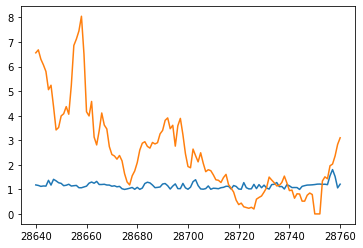

In [475]:
plt.plot(test_oriented.loc[28600+train_seq:28800-train_seq, 'Wspd'])
plt.plot(test_oriented.loc[28600+train_seq:28800-train_seq, 'Wspd_y'])